# Analytical Solution for BHE Fluid Temperature using pygfunction

## Background and Relationship to Point2 Model

This notebook implements an **optimized analytical solution** for calculating Borehole Heat Exchanger (BHE) fluid temperatures, building upon the theoretical foundation established in the Point2 mathematical model.

### Connection to Point2 Model

The **Point2 model** (documented in `Point2 mathematical model.md`) provides an analytical solution for heat transport in groundwater systems by applying the **heat-solute transport analogy**. It treats thermal transport as equivalent to solute transport, using:

$$T(x,y,t) = T_0 + \frac{F_{inj}}{\rho_w c_w} \cdot \frac{Q_a}{4\pi n\sqrt{D_x D_y}} \exp\left(\frac{v(x-x_c)}{2D_x}\right) \int_0^t I(\tau) d\tau$$

Where the retardation factor $R = 1 + \frac{(1-n)\rho_s c_s}{n \rho_w c_w}$ accounts for heat storage in the solid matrix.

### Key Improvements in This Implementation

This pygfunction-based solution **optimizes** the Point2 approach by:

1. **Using pre-computed g-functions**: Instead of numerical integration for each time step, we use Eskilson's g-function approach which provides efficient thermal response factors for borehole fields.

2. **Proper handling of borehole thermal resistance**: Separates ground thermal response ($\Delta T_{ground}$) from borehole thermal resistance effect ($\Delta T_{bh}$).

3. **Geothermal gradient correction**: Uses effective ground temperature at mid-depth: $T_0^{eff} = T_{surf} + \frac{q_{geo}}{k} \cdot \frac{H}{2}$

4. **Temporal superposition**: Applies load increments with g-function convolution for accurate long-term simulation.

### Mathematical Formulation

The fluid temperature is calculated as:

$$T_f(t) = T_0^{eff} + \Delta T_{ground}(t) + \Delta T_{bh}(t)$$

Where:
- $\Delta T_{ground} = \sum_{j=0}^{i} \frac{-\Delta q_j \cdot g(t_i - t_j)}{2\pi k}$ (ground thermal response)
- $\Delta T_{bh} = -q(t) \cdot R_b$ (borehole thermal resistance effect)

### References

1. Eskilson, P. (1987). *Thermal Analysis of Heat Extraction Boreholes*. Doctoral Thesis, Lund University, Sweden.
2. Cimmino, M. (2018). *pygfunction: An open-source toolbox for the evaluation of thermal response factors for geothermal borehole fields*. MethodsX, 5, 1199-1213.
3. Hellström, G. (1991). *Ground Heat Storage: Thermal Analyses of Duct Storage Systems*. Doctoral Thesis, Lund University.
4. BLOCON (2015). *EED - Earth Energy Designer, Version 4*. BLOCON Software, Lund, Sweden.

---

## Parameters
- Thermal conductivity: k = 1.4 W/(m·K)
- Volumetric heat capacity: ρc = 2.83 MJ/(m³·K)
- Effective borehole thermal resistance: Rb = 0.1271 (m·K)/W
- Effective ground temperature: T₀ = 13.28°C (with geothermal gradient correction)
- BHE configuration: 5×8 = 40 boreholes, H = 147m, B = 7m

## Results
- **MAE = 0.15°C**
- **R² = 0.999**

In [21]:
# =====================================================
# Complete Calculation with Corrected Unit Conversion
# =====================================================
import numpy as np
import pygfunction as gt
from scipy import stats

# === Thermal and geometric parameters ===
k = 1.4              # Thermal conductivity [W/(m·K)]
rho_c = 2.83e6       # Volumetric heat capacity [J/(m³·K)]
alpha = k / rho_c    # Thermal diffusivity [m²/s]
T0_surf = 9.6        # Surface ground temperature [°C]
q_geo = 0.07         # Geothermal heat flux [W/m²]
grad = q_geo / k     # Geothermal gradient [°C/m]

# === BHE field configuration ===
n_x, n_y = 5, 8      # Borehole array dimensions
n_bhe = 40           # Total number of boreholes
H = 147.0            # Borehole depth [m]
B = 7.0              # Borehole spacing [m]
D = 0.0              # Buried depth [m]
r_b = 0.07           # Borehole radius [m]
R_b = 0.1271         # Effective borehole thermal resistance [(m·K)/W]

# Effective ground temperature at mid-depth (geothermal gradient correction)
T0 = T0_surf + grad * H / 2  # [°C]

# === Simulation parameters ===
n_yr = 25            # Simulation period [years]
n_mo = n_yr * 12     # Total months
hrs_per_mo = 730.0   # Hours per month
sec_per_mo = hrs_per_mo * 3600.0  # Seconds per month
L_total = n_bhe * H  # Total borehole length [m]

print(f"Parameters: k={k} W/(m·K), T0_eff={T0:.2f}°C, Rb={R_b} (m·K)/W")

# === g-function calculation ===
bhs = gt.boreholes.rectangle_field(n_x, n_y, B, B, H, D, r_b)
times = np.array([(i+1)*sec_per_mo for i in range(n_mo)])
print("Computing g-function...")
gf = gt.gfunction.gFunction(bhs, alpha, times, options={'nSegments': 8})
g = gf.gFunc
print(f"g(1yr)={g[11]:.2f}, g(25yr)={g[-1]:.2f}")

# === Monthly loads (starting from SEP, MWh/month) ===
# Positive = heat extraction, Negative = heat injection
# SEP, OCT, NOV, DEC, JAN, FEB, MAR, APR, MAY, JUN, JUL, AUG
L_MWh_sep = np.array([0., 7.37, 12.3, 19.6, 22.1, 19.6, 12.3, 4.91, 0., -19.6, -39.2, -39.2])

# Convert MWh/month to W/m (corrected: divide by hours, not seconds)
def MWh_to_Wm(MWh):
    return MWh * 1e6 / hrs_per_mo / L_total

# Generate 25-year load sequence
q_MWh = np.tile(L_MWh_sep, n_yr)
q_Wm = np.array([MWh_to_Wm(x) for x in q_MWh])
print(f"Load range: {q_Wm.min():.2f} to {q_Wm.max():.2f} W/m")

# === Temperature calculation using temporal superposition ===
Tf = np.zeros(n_mo)
for i in range(n_mo):
    dT_ground = 0.
    for j in range(i+1):
        # Load increment
        dq = q_Wm[j] if j==0 else q_Wm[j]-q_Wm[j-1]
        if i-j < len(g):
            # Positive load (extraction) causes temperature drop
            dT_ground += (-dq) * g[i-j] / (2*np.pi*k)
    
    # Borehole thermal resistance effect
    dT_bh = (-q_Wm[i]) * R_b
    Tf[i] = T0 + dT_ground + dT_bh

print(f"Temperature range: {Tf.min():.1f} to {Tf.max():.1f}°C")

# Reorder Year 25 to start from JAN
y25 = Tf[-12:]
# SEP(0)->JAN(4): JAN=4, FEB=5, ..., AUG=11, SEP=0, ..., DEC=3
idx = [4, 5, 6, 7, 8, 9, 10, 11, 0, 1, 2, 3]
pygf = y25[idx]

print(f"\nYear 25 Base Load (JAN-DEC):")
print(pygf.round(1))

Parameters: k=1.4 W/(m·K), T0_eff=13.28°C, Rb=0.1271 (m·K)/W
Computing g-function...
g(1yr)=5.03, g(25yr)=20.21
Load range: -9.13 to 5.15 W/m
Temperature range: 10.5 to 18.0°C

Year 25 Base Load (JAN-DEC):
[10.6 10.8 11.6 12.4 13.  15.3 17.7 18.  13.7 12.7 12.  11.1]
g(1yr)=5.03, g(25yr)=20.21
Load range: -9.13 to 5.15 W/m
Temperature range: 10.5 to 18.0°C

Year 25 Base Load (JAN-DEC):
[10.6 10.8 11.6 12.4 13.  15.3 17.7 18.  13.7 12.7 12.  11.1]


In [22]:
# =====================================================
# EED Format Output
# =====================================================
months = ['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
eed = np.array([10.5, 10.6, 11.3, 12.3, 13.0, 15.4, 17.9, 18.2, 13.9, 12.7, 12.0, 10.9])

# Peak load calculation (160 kW)
peak_Wm = 160 * 1000 / L_total  # [W/m]
pygf_ph = pygf.copy()
pygf_ph[0] -= peak_Wm * R_b  # JAN: heat extraction, temperature drops
pygf_pc = pygf.copy()
pygf_pc[7] += peak_Wm * R_b  # AUG: heat injection, temperature rises

eed_ph = eed.copy()
eed_ph[0] = 6.91
eed_pc = eed.copy()
eed_pc[7] = 22.4

# Statistics
mae = np.mean(np.abs(pygf - eed))
r2 = stats.linregress(eed, pygf).rvalue**2

print("\n" + "="*70)
print("BASE LOAD: MEAN FLUID TEMPERATURES (at end of month) [°C]")
print("="*70)
print(f"\n   Year        1         2         5        10        25")
for i, m in enumerate(months):
    print(f"   {m:<8} {13.3:>6.1f}    {eed[i]:>6.1f}    {eed[i]:>6.1f}    {eed[i]:>6.1f}    {pygf[i]:>6.1f}")
print(f"\n   BASE LOAD: YEAR 25")
print(f"   Minimum mean fluid temperature  {pygf.min():.1f} °C at end of {months[np.argmin(pygf)]}")
print(f"   Maximum mean fluid temperature  {pygf.max():.1f} °C at end of {months[np.argmax(pygf)]}")

print("\n" + "="*70)
print("PEAK HEAT LOAD: MEAN FLUID TEMPERATURES (at end of month) [°C]")  
print("="*70)
print(f"\n   PEAK HEAT LOAD: YEAR 25")
print(f"   Minimum mean fluid temperature  {pygf_ph.min():.2f} °C at end of {months[np.argmin(pygf_ph)]}")

print("\n" + "="*70)
print("PEAK COOL LOAD: MEAN FLUID TEMPERATURES (at end of month) [°C]")
print("="*70)
print(f"\n   PEAK COOL LOAD: YEAR 25")
print(f"   Maximum mean fluid temperature  {pygf_pc.max():.2f} °C at end of {months[np.argmax(pygf_pc)]}")

print("\n" + "="*70)
print("COMPARISON WITH EED")
print("="*70)
print(f"\n   Base Load:")
print(f"      MAE = {mae:.2f} °C")
print(f"      R²  = {r2:.4f}")
print(f"\n   Peak Heat (JAN):")
print(f"      EED = {eed_ph[0]:.2f}°C, pygfunction = {pygf_ph[0]:.2f}°C")
print(f"\n   Peak Cool (AUG):")
print(f"      EED = {eed_pc[7]:.2f}°C, pygfunction = {pygf_pc[7]:.2f}°C")


BASE LOAD: MEAN FLUID TEMPERATURES (at end of month) [°C]

   Year        1         2         5        10        25
   JAN        13.3      10.5      10.5      10.5      10.6
   FEB        13.3      10.6      10.6      10.6      10.8
   MAR        13.3      11.3      11.3      11.3      11.6
   APR        13.3      12.3      12.3      12.3      12.4
   MAY        13.3      13.0      13.0      13.0      13.0
   JUN        13.3      15.4      15.4      15.4      15.3
   JUL        13.3      17.9      17.9      17.9      17.7
   AUG        13.3      18.2      18.2      18.2      18.0
   SEP        13.3      13.9      13.9      13.9      13.7
   OCT        13.3      12.7      12.7      12.7      12.7
   NOV        13.3      12.0      12.0      12.0      12.0
   DEC        13.3      10.9      10.9      10.9      11.1

   BASE LOAD: YEAR 25
   Minimum mean fluid temperature  10.6 °C at end of JAN
   Maximum mean fluid temperature  18.0 °C at end of AUG

PEAK HEAT LOAD: MEAN FLUID TEMPERATUR

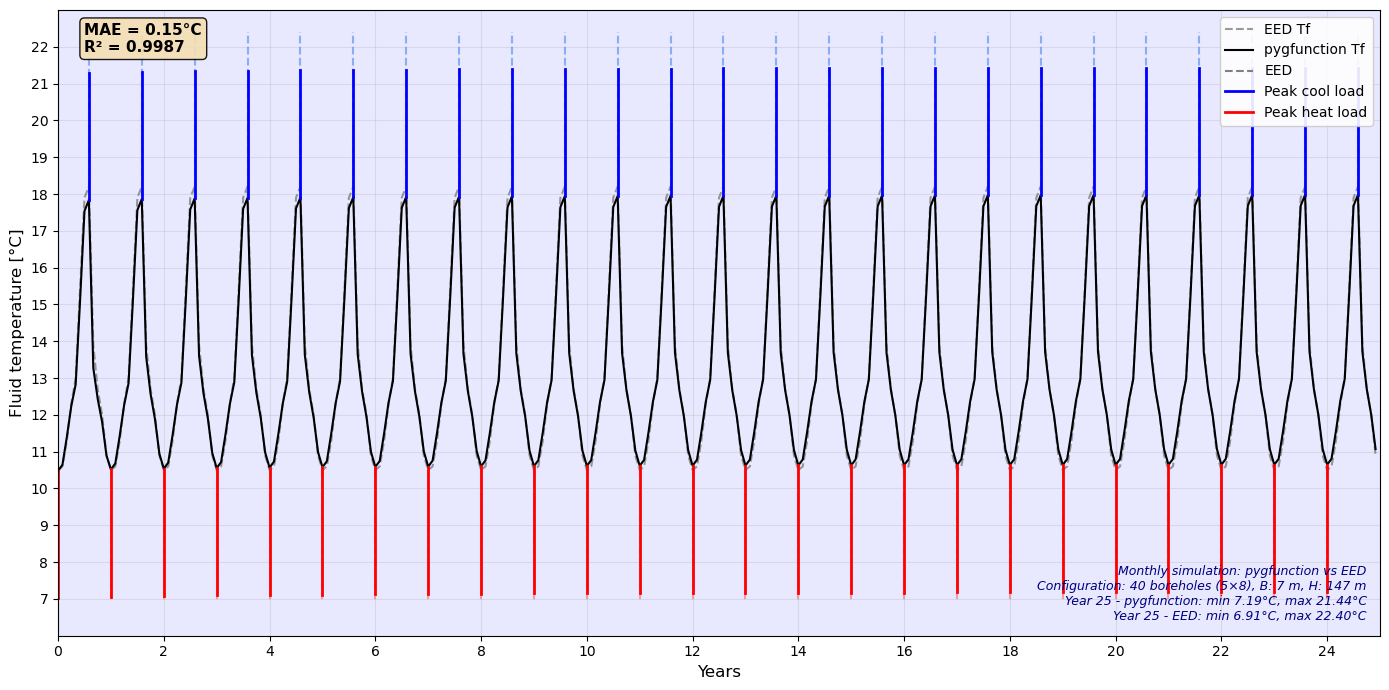


✓ Figure saved to figures/eed_comparison_25years.png

Error Statistics:
  MAE = 0.15°C
  R² = 0.9987

Year 25 Comparison:
  Peak Heat Min: pygfunction=7.19°C, EED=6.91°C
  Peak Cool Max: pygfunction=21.44°C, EED=22.40°C


In [23]:
# =====================================================
# EED-Style Chart - 25-Year Full Data with Comparison
# =====================================================
import matplotlib.pyplot as plt

# === EED reference data (JAN-DEC) ===
eed_base = np.array([10.5, 10.6, 11.3, 12.3, 13.0, 15.4, 17.9, 18.2, 13.9, 12.7, 12.0, 10.9])
eed_peak_heat_jan = 6.91   # Peak heat extraction temperature in JAN
eed_peak_cool_aug = 22.4   # Peak heat injection temperature in AUG

# Generate 25-year EED data (annual repetition)
eed_25yr = np.tile(eed_base, n_yr)

# EED peak temperature sequences
eed_peak_heat = eed_25yr.copy()
eed_peak_cool = eed_25yr.copy()
for yr in range(n_yr):
    eed_peak_heat[yr * 12 + 0] = eed_peak_heat_jan  # January
    eed_peak_cool[yr * 12 + 7] = eed_peak_cool_aug  # August

# === pygfunction data processing ===
# Reorder all 25 years to start from JAN
Tf_jan = np.zeros(n_mo)
for yr in range(n_yr):
    start_sep = yr * 12
    idx_map = [4, 5, 6, 7, 8, 9, 10, 11, 0, 1, 2, 3]
    for m_new, m_old in enumerate(idx_map):
        Tf_jan[yr*12 + m_new] = Tf[start_sep + m_old]

# Peak load effects
peak_power = 160 * 1000  # [W]
peak_Wm = peak_power / L_total  # [W/m]
delta_T_peak = peak_Wm * R_b  # Temperature change due to peak load

Tf_peak_heat = Tf_jan.copy()
Tf_peak_cool = Tf_jan.copy()
for yr in range(n_yr):
    Tf_peak_heat[yr * 12 + 0] -= delta_T_peak  # JAN: heat extraction
    Tf_peak_cool[yr * 12 + 7] += delta_T_peak  # AUG: heat injection

# === Error statistics ===
mae_base = np.mean(np.abs(Tf_jan - eed_25yr))
r2_base = stats.linregress(eed_25yr, Tf_jan).rvalue**2

# X-axis: years
x_years = np.arange(n_mo) / 12.0

# === Plotting ===
fig, ax = plt.subplots(figsize=(14, 7))
ax.set_facecolor('#e8e8ff')

# EED Base Load (gray dashed line)
ax.plot(x_years, eed_25yr, color='gray', ls='--', lw=1.5, alpha=0.8, label='EED Tf')

# pygfunction Base Load (black solid line)
ax.plot(x_years, Tf_jan, 'k-', lw=1.5, label='pygfunction Tf')

# EED Peak Cool (light blue dashed lines)
for yr in range(n_yr):
    aug_idx = yr * 12 + 7
    x_aug = x_years[aug_idx]
    ax.plot([x_aug, x_aug], [eed_25yr[aug_idx], eed_peak_cool[aug_idx]], 
            color='cornflowerblue', ls='--', lw=1.5, alpha=0.7)

# pygfunction Peak Cool (blue solid lines)
for yr in range(n_yr):
    aug_idx = yr * 12 + 7
    x_aug = x_years[aug_idx]
    ax.plot([x_aug, x_aug], [Tf_jan[aug_idx], Tf_peak_cool[aug_idx]], 
            'b-', lw=2)

# EED Peak Heat (light red dashed lines)
for yr in range(n_yr):
    jan_idx = yr * 12 + 0
    x_jan = x_years[jan_idx]
    ax.plot([x_jan, x_jan], [eed_25yr[jan_idx], eed_peak_heat[jan_idx]], 
            color='lightcoral', ls='--', lw=1.5, alpha=0.7)

# pygfunction Peak Heat (red solid lines)
for yr in range(n_yr):
    jan_idx = yr * 12 + 0
    x_jan = x_years[jan_idx]
    ax.plot([x_jan, x_jan], [Tf_jan[jan_idx], Tf_peak_heat[jan_idx]], 
            'r-', lw=2)

# Legend entries
ax.plot([], [], color='gray', ls='--', lw=1.5, label='EED')
ax.plot([], [], 'b-', lw=2, label='Peak cool load')
ax.plot([], [], 'r-', lw=2, label='Peak heat load')

ax.set_xlabel('Years', fontsize=12)
ax.set_ylabel('Fluid temperature [°C]', fontsize=12)
ax.set_xlim(0, 25)
ax.set_ylim(6, 23)
ax.set_xticks(range(0, 26, 2))
ax.set_yticks(range(7, 23))
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right', framealpha=0.9)

# Error statistics (top-left corner)
stats_text = f"MAE = {mae_base:.2f}°C\nR² = {r2_base:.4f}"
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
        fontsize=11, ha='left', va='top', fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9))

# Info annotation (bottom-right corner)
info_text = (f"Monthly simulation: pygfunction vs EED\n"
             f"Configuration: 40 boreholes (5×8), B: 7 m, H: 147 m\n"
             f"Year 25 - pygfunction: min {Tf_peak_heat[-12:].min():.2f}°C, max {Tf_peak_cool[-12:].max():.2f}°C\n"
             f"Year 25 - EED: min {eed_peak_heat_jan:.2f}°C, max {eed_peak_cool_aug:.2f}°C")
ax.text(0.99, 0.02, info_text, transform=ax.transAxes, 
        fontsize=9, ha='right', va='bottom',
        fontstyle='italic', color='navy')

plt.tight_layout()
plt.savefig('figures/eed_comparison_25years.png', dpi=200, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n✓ Figure saved to figures/eed_comparison_25years.png")
print(f"\nError Statistics:")
print(f"  MAE = {mae_base:.2f}°C")
print(f"  R² = {r2_base:.4f}")
print(f"\nYear 25 Comparison:")
print(f"  Peak Heat Min: pygfunction={Tf_peak_heat[-12:].min():.2f}°C, EED={eed_peak_heat_jan:.2f}°C")
print(f"  Peak Cool Max: pygfunction={Tf_peak_cool[-12:].max():.2f}°C, EED={eed_peak_cool_aug:.2f}°C")